In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial import distance

In [72]:
class node:
    def __init__(self, x, y, indPre=0):
        self.x = [x]
        self.y = [y]
        self.indPre = [indPre]
        
class path:
    def __init__(self, x, y):
        self.x = [x]
        self.y = [y]

In [73]:
def line_check(axis1, axis2, gray_img):
    limit_range = 5
    if axis1[1] > axis2[1]:
        y_list = np.arange(int(axis2[1])-limit_range,int(axis1[1])+limit_range)
    elif axis1[1] < axis2[1]:
        y_list = np.arange(int(axis1[1])-limit_range, int(axis2[1])+limit_range)
    else:
        y_list = np.arange(int(axis1[1])-limit_range, int(axis1[1])+limit_range)
        
    if axis1[0] > axis2[0]:
        x_list = np.arange(int(axis2[0])-limit_range,int(axis1[0])+limit_range)
    elif axis1[0] < axis2[0]:
        x_list = np.arange(int(axis1[0])-limit_range, int(axis2[0])+limit_range)
    else:
        x_list = np.arange(int(axis1[0])-limit_range, int(axis1[0])+limit_range)
    
    for y in y_list:
        for x in x_list:
            gray_num = gray_img[y][x][0]
            if gray_num <= 205:
                return 1
    return 0

def check_in_boundary(axis, gray_img, limit_range):
    y_list = np.arange(int(axis[1])-limit_range, int(axis[1])+limit_range)
    x_list = np.arange(int(axis[0])-limit_range, int(axis[0])+limit_range)
    for y in y_list:
        for x in x_list:
            gray_num = gray_img[y][x][0]   
            if gray_num <= 205:
                return 1
    return 0

def recursive_refine(refining_path):
    length = len(refining_path[0])
    min_angle = 9999999
    min_angle_index = 0
    
    for i in range(1, length):
        x_diff = refining_path[0][0] - refining_path[0][i]
        y_diff = refining_path[1][0] - refining_path[1][i]
        angle = abs(math.atan(y_diff/x_diff) * (180/math.pi))
        
        CheckInBound = check_in_boundary([refining_path[0][i], refining_path[1][i]], gray_img, 15)
        if CheckInBound == 1:
            continue
        
        if min_angle > angle:
            min_angle = angle
            min_angle_index = i
            
    refined_path[0].append(refining_path[0][0])
    refined_path[1].append(refining_path[1][0])
    refining_path = [refining_path[0][min_angle_index:], refining_path[1][min_angle_index:]]
    
    if len(refining_path[0][min_angle_index:]) != 1:
        recursive_refine(refining_path)
    
def PathRefine(path):
    global refined_path
    pathLength = len(path.x)
    vector_x_pos = []
    vector_y_pos = []

    for i in range(pathLength):
        vector_x_pos.append(path.x[i])
        vector_y_pos.append(path.y[i])
    
    tempPath_refine = [vector_x_pos, vector_y_pos]
    refined_path = [[], []]        
    recursive_refine(tempPath_refine)
    
    return refined_path

In [74]:
def sqrt_mse(front, back):
    return math.sqrt(2*((math.pow(front[0]-back[0], 2)) + math.pow(front[1]-back[1], 2)))

def interval_check(front, waypoint, tmp_interval):
    real_interval = sqrt_mse(front, waypoint)
    if real_interval < (tmp_interval-15) or real_interval > (tmp_interval+15):
        return 1
    else:
        return 0

def rand_check(rand_axis, benchmark, angle, theta):
    rand_angle = math.degrees(math.atan2(rand_axis[1]-benchmark[1],rand_axis[0]-benchmark[0]))
    if rand_angle < (angle-theta) or rand_angle > (angle+theta):
        return 1
    else: 
        return 0

In [75]:
def find_near_neighbor(node, new_axis, set_radius):
    index = []
    for i in range(len(node.x)):
        x_neighbor = [node.x[i], node.y[i]]
        if distance.euclidean(new_axis, x_neighbor) < set_radius:
            index.append(i)
            
    return index

def make_cost(pre, cur, add, control, key):
    if control < key:
        cur_angle = math.degrees(math.atan2(add[1]-cur[1],add[0]-cur[0]))
        pre_angle = math.degrees(math.atan2(cur[1]-pre[1],cur[0]-pre[0]))
        diff_angle = abs(pre_angle-cur_angle)
        dist = distance.euclidean(add, cur)
    else:
        cur_angle = math.degrees(math.atan2(pre[1]-cur[1],pre[0]-cur[0]))
        pre_angle = math.degrees(math.atan2(cur[1]-add[1],cur[0]-add[0]))
        diff_angle = abs(pre_angle-cur_angle)
        dist = distance.euclidean(add, goal)
        
    cost = diff_angle + dist
    
    return cost

def bermuda(indPre, index):
    tmp_index = indPre[index]
    while True:
        if tmp_index == index:
            return 1
        else:
            tmp_index = indPre[tmp_index]
        
        if tmp_index == 0:
            break
            
    return 0

In [76]:
def create_waypoint(m, interval):
    x_way = []
    number = int(sqrt_mse(START[m], END[m]) / interval)
    while True:
        if m == 0 or m == 2:
            if len(x_way) == 0:
                x_way_rand = [START[m][0] + (END[m][0]-START[m][0])* np.random.rand(1), START[m][1] + (END[m][1]-START[m][1])* np.random.rand(1)]
                IntervalCheck = interval_check(START[m], x_way_rand, interval)
            else:
                x_way_rand = [pre_x_way[0] + (END[m][0]-pre_x_way[0])* np.random.rand(1), START[m][1] + (END[m][1]-START[m][1])* np.random.rand(1)]
                IntervalCheck = interval_check(pre_x_way, x_way_rand, interval)
                
            CheckInBoundWaypoint = check_in_boundary(x_way_rand, gray_img, 15)
        elif m == 1:
            if len(x_way) == 0:
                x_way_rand = [START[m][0] + (END[m][0]-START[m][0])* np.random.rand(1), START[m][1] + (END[m][1]-START[m][1])* np.random.rand(1)]
                IntervalCheck = interval_check(START[m], x_way_rand, interval)
            else:
                x_way_rand = [START[m][0] + (END[m][0]-START[m][0])* np.random.rand(1), pre_x_way[1] + (END[m][1]-pre_x_way[1])* np.random.rand(1)]
                IntervalCheck = interval_check(pre_x_way, x_way_rand, interval)
            
            CheckInBoundWaypoint = check_in_boundary(x_way_rand, gray_img, 20)
        
        if CheckInBoundWaypoint == 1 or IntervalCheck == 1:
            continue
        
        x_way.append(x_way_rand)
        pre_x_way = x_way_rand
        ax.plot(x_way_rand[0], x_way_rand[1], 'md', markersize = 10, linewidth=1)
        
        if len(x_way) == number:
            return [x_way, number]
    
def prepare_waypoint():
    user_waypoint = []
    user_waypoint_angle = []
    user_waypoint.append(START[0])
    region_zero, number_zero = create_waypoint(0, 250)
    region_one, number_one = create_waypoint(1, 400)
    region_two, number_two = create_waypoint(2, 300)
    user_waypoint = user_waypoint + region_zero + region_one + region_two
    user_waypoint.append(END[2])
    for j in range(len(user_waypoint)-1):
        angle = math.degrees(math.atan2(user_waypoint[j+1][1]-user_waypoint[j][1],user_waypoint[j+1][0]-user_waypoint[j][0]))
        user_waypoint_angle.append(angle)
    
    return [user_waypoint, user_waypoint_angle, number_zero, number_one, number_two]

In [77]:
def RRT(node, path, start, end, theta, range_num):
    u = 0
    ax.imshow(img)
    user_waypoint, user_waypoint_angle, zero, one, two = prepare_waypoint()
    
    for i in range(1, range_num):
        if u < zero:
            x_rand = [user_waypoint[u][0] + (user_waypoint[u+1][0]-user_waypoint[u][0])* np.random.rand(1), START[0][1] + (END[0][1]-START[0][1])* np.random.rand(1)] 
        elif u < zero + one:
            x_rand = [START[1][0] + (END[1][0]-START[1][0])* np.random.rand(1), user_waypoint[u][1] + (user_waypoint[u+1][1]-user_waypoint[u][1])* np.random.rand(1)]
        else:
            x_rand = [user_waypoint[u][0] + (user_waypoint[u+1][0]-user_waypoint[u][0])* np.random.rand(1), user_waypoint[u][1] + (user_waypoint[u+1][1]-user_waypoint[u][1])* np.random.rand(1)]
    
        if u == zero or u == zero + one:
            THETA = 70
        else:
            THETA = theta
        
        RandCheck = rand_check(x_rand, user_waypoint[u], user_waypoint_angle[u], THETA)
        
        if RandCheck == 1:
            continue
        
        min_dist = 9999999
        near_iter = 0
        min_cost = 9999999
        cost_iter = 0
        N = len(node.x)
   
        for j in range(N):
            x_near = [node.x[j], node.y[j]]
            dist = distance.euclidean(x_rand, x_near)
            if min_dist > dist:
                min_dist = dist
                near_iter = j
            
        x_near = [node.x[near_iter], node.y[near_iter]]
            
        near_rand = [x_rand[0]-x_near[0], x_rand[1]-x_near[1]]
        normlized = [near_rand[0] / distance.euclidean(x_rand, x_near)*stepsize, near_rand[1] / distance.euclidean(x_rand, x_near)*stepsize]
        x_new = [x_near[0] + normlized[0], x_near[1] + normlized[1]] 
        
        CheckInBoundNew = check_in_boundary(x_new, gray_img, 10)
        LineCheck = line_check(x_new, x_near, gray_img)
        
        if CheckInBoundNew == 1 or LineCheck == 1:
            continue
        ######### choose parent #########    
        neighbor_index = find_near_neighbor(node, x_new, 20)
        if neighbor_index:
            for k in neighbor_index:
                cur_cost = [node.x[k], node.y[k]]
                pre_cost = [node.x[node.indPre[k]], node.y[node.indPre[k]]]
                cost = make_cost(pre_cost, cur_cost, x_new, u, zero+one)
                    
                if min_cost > cost:
                    min_cost = cost
                    cost_iter = k
        
        x_cost = [node.x[cost_iter], node.y[cost_iter]]
        
        LineCheck2 = line_check(x_new, x_cost, gray_img)
        
        if LineCheck2 == 1:
            continue
        
        node.x.append(x_new[0])
        node.y.append(x_new[1])
        node.indPre.append(cost_iter)
        new_iter = len(node.x)-1
        ax.plot([x_cost[0], x_new[0]], [x_cost[1], x_new[1]], 'b-', linewidth=2)
        
        if distance.euclidean(x_new, end) < 5:
            break
        
        if u < zero:
            if  x_new[0] >= user_waypoint[u+1][0]:
                print("reach waypoint")
                u += 1
        elif u < zero + one:
            if abs(user_waypoint[u][0] - user_waypoint[u+1][0]) >= 30:
                if x_new[1] >= user_waypoint[u+1][1]:
                    print("reach waypoint")
                    u += 1
            else:
                if distance.euclidean(x_new, user_waypoint[u+1]) < 10:
                    print("reach waypoint")
                    u += 1
        elif u < zero + one + two:
            if x_new[0] <= user_waypoint[u+1][0]:
                print("reach waypoint")
                u += 1
        
        #################################
        ############# rewire ############
        new_child_index_list = [] 
        
        if neighbor_index:
            for i in neighbor_index:
                if i != cost_iter and i != 0:
                    x_child = [node.x[i], node.y[i]]
                    x_parent = [node.x[node.indPre[i]], node.y[node.indPre[i]]]
                    x_grand_parent = [node.x[node.indPre[node.indPre[i]]], node.y[node.indPre[node.indPre[i]]]]
                    new_cost = make_cost(x_cost, x_new, x_child, u, zero+one)
                    neighbor_cost = make_cost(x_grand_parent, x_parent, x_child, u, zero+one)
                    
                    if new_cost < neighbor_cost:
                        LineCheck3 = line_check(x_child, x_new, gray_img)
                        if LineCheck3 == 1:
                            continue
                
                        new_child_index_list.append(i)
                        
        if new_child_index_list:
            for k in new_child_index_list:
                pre_iter = node.indPre[k]
                new_child = [node.x[k], node.y[k]] 
                node.indPre[k] = new_iter
                Bermuda = bermuda(node.indPre, k)
                if Bermuda == 1:
                    node.indPre[k] = pre_iter
                    continue
                
                ax.plot([x_new[0], new_child[0]], [x_new[1], new_child[1]], 'b-', linewidth=2)
        #################################

    if True:
        path.x[0] = end[0]
        path.y[0] = end[1]
        path.x.append(node.x[-1])
        path.y.append(node.y[-1])
        path_index = node.indPre[-1]

        while True:
            path.x.append(node.x[path_index])
            path.y.append(node.y[path_index])
            path_index = node.indPre[path_index]
            if path_index == 0:
                break

        path.x.append(start[0])
        path.y.append(start[1])
        Range_Num = len(path.x)
        for j in range(1, Range_Num):
            ax.plot([path.x[j], path.x[j-1]], [path.y[j], path.y[j-1]], 'r:', linewidth=2)
    else:
        print('no path to end')

In [78]:
def set_params():
    global stepsize, robot, goal, v, pos, START, END
    stepsize = 10
    robot = [50, 150]
    goal = [220, 1350]
    START = [[50, 130], [1250, 130], [1250, 1250]]
    END = [[1400, 180], [1380, 1300], [220, 1360]]
    v = node(robot[0], robot[1])
    pos = path(0, 0)

In [79]:
def station():
    set_params()
    global img, gray_img, fig, ax
    img = cv2.imread('obstacle.jpg')

    gray_img = np.asarray(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    binary = cv2.bitwise_not(binary)

    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_title('Local map with an obstacle and line constraints', fontsize=40)
    ax.imshow(img)

    ax.set_xlim([0, 1500])
    ax.set_ylim([0, 1440])
   
    ax.plot(robot[0], robot[1], 'rd', markersize = 10, linewidth=1)
    ax.plot(goal[0], goal[1], 'rd', markersize = 10, linewidth=1)

    RRT(v, pos, robot, goal, 40, 6001)
'''
    Final_path = PathRefine(pos)
    final_length = len(Final_path[0])

    for i in range(final_length-1):
        ax.plot([Final_path[0][i], Final_path[0][i+1]], [Final_path[1][i], Final_path[1][i+1]],  'k--', linewidth=2)
'''        

"\n    Final_path = PathRefine(pos)\n    final_length = len(Final_path[0])\n\n    for i in range(final_length-1):\n        ax.plot([Final_path[0][i], Final_path[0][i+1]], [Final_path[1][i], Final_path[1][i+1]],  'k--', linewidth=2)\n"

C:\Users\tjdgu\anaconda3\envs\tf\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


reach waypoint
reach waypoint
reach waypoint
reach waypoint
reach waypoint
reach waypoint
reach waypoint
reach waypoint
reach waypoint
reach waypoint
reach waypoint
reach waypoint
reach waypoint
reach waypoint
reach waypoint


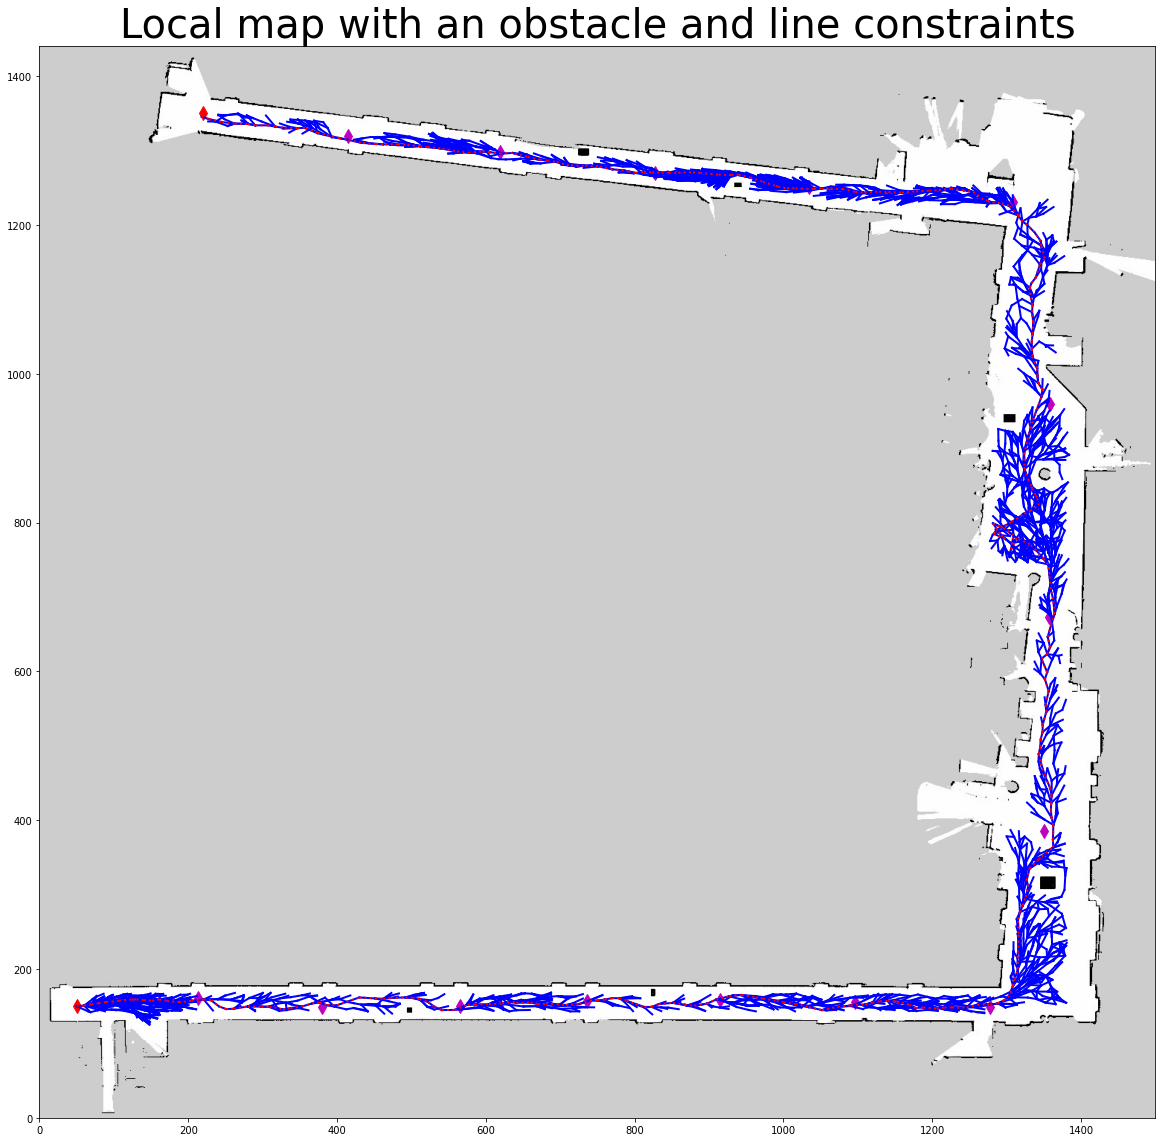

In [80]:
if __name__ == "__main__":
    station()   